In [8]:
# Used to pull data from Reddit
import praw
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import statsmodels.formula.api
import matplotlib.pyplot as plt
import time
import re


from gensim.models import Word2Vec
from nltk.corpus import brown
import nltk
import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras as keras 
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

import tensorflow_hub as hub
import multiprocessing
from google.cloud import bigquery

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

from sklearn import model_selection
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import pipeline

import warnings
warnings.filterwarnings("ignore")

#nltk.download('punkt')

In [2]:
#post_df.to_csv('reddit_posts_2016_2019.csv')
start_time = time.time()
post_df = pd.read_csv('reddit_posts_2016_2019.csv', parse_dates=['created_dt_month'])

In [ ]:
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replace_links(text, filler=' '):
        text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                      filler, text).strip()
        return text

def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = replace_contraction(text)
    text = replace_links(text, "urltoken")
    #text = remove_numbers(text)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = text.lower()
    return text


# Data Import

In [ ]:
# Read in cleaned up data
post_df = pd.read_json('complete_elmo.json', orient='split', dtype={'elmo_embedding':'float32'})
post_df['elmo_embedding'] = post_df['elmo_embedding'].apply(lambda x: np.array(x, dtype='float32'))

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(post_df['elmo_embedding'].tolist(),
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

#

In [142]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(post_df['title_clean'],
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

In [145]:
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(X_train)

X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [176]:
# Define classifier, over sampler, under sampler and feature selector
pipe_model = RandomForestClassifier(n_jobs=10, n_estimators=100)
osmpl = over_sampling.SMOTE(n_jobs=10)
usmpl = under_sampling.TomekLinks(n_jobs=10)

# Create pipeline
pipe = pipeline.Pipeline([('over_sampler', osmpl), ('under_sampler', usmpl), ('classifier', pipe_model)])

# Fit pipeline
start_time = time.time()
pipe.fit(X_train_transformed, y_train)
print('%s seconds' % (time.time() - start_time))

49.8859589099884 seconds


In [172]:
model = RandomForestClassifier(n_jobs=10, n_estimators=100)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=10, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [177]:
print('Dummy Model')
print(metrics.classification_report(y_test, np.zeros(y_test.shape[0])))
print('tfidf With Over/Under Sampling')
print(metrics.classification_report(y_test, pipe.predict(X_test_transformed)))
print('tfidf With No Over/Under Sampling')
print(metrics.classification_report(y_test, model.predict(X_test_transformed)))

Dummy Model
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      3604
           1       0.00      0.00      0.00      1836

    accuracy                           0.66      5440
   macro avg       0.33      0.50      0.40      5440
weighted avg       0.44      0.66      0.53      5440

tfidf With Over/Under Sampling
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      3604
           1       0.63      0.64      0.64      1836

    accuracy                           0.75      5440
   macro avg       0.73      0.73      0.73      5440
weighted avg       0.75      0.75      0.75      5440

tfidf With No Over/Under Sampling
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      3604
           1       0.73      0.52      0.61      1836

    accuracy                           0.77      5440
   macro avg       0.76      0.71      0.72      54

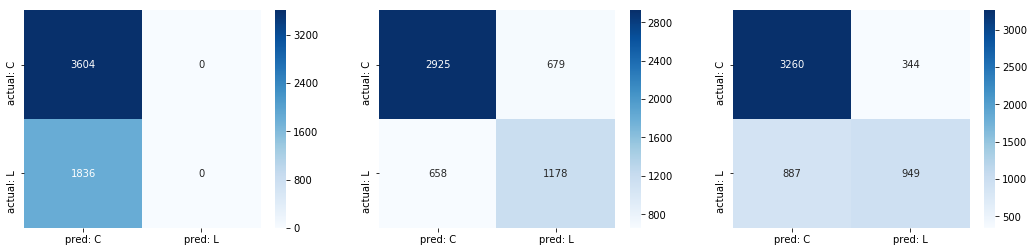

In [178]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
sns.heatmap(metrics.confusion_matrix(y_test, np.zeros(y_test.shape[0])), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues', 
            ax=ax[0])

sns.heatmap(metrics.confusion_matrix(y_test, pipe.predict(X_test_transformed)), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[1])

sns.heatmap(metrics.confusion_matrix(y_test, model.predict(X_test_transformed)), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[2])

plt.show()

In [113]:
post_df['word_token'] = post_df['title_clean'].apply(nltk.word_tokenize)

In [138]:

test_token = tfidf.fit_transform(post_df['title_clean'].tolist())

In [140]:
test_token.shape

(27198, 18300)

In [137]:
tfidf.get_feature_names().shape

AttributeError: 'list' object has no attribute 'shape'

In [121]:
post_df['tfidf_token'] = post_df['word_token'].apply(lambda x: TfidfVectorizer(input=x, stop_words='english'))

In [122]:
post_df.head()

,title_clean,elmo_embedding,political_leaning,word_token,tfidf_token
0,what was the moment or event that made you rea...,"[-0.078861244, -0.113778666, 0.0038933286, -0....",0,"[what, was, the, moment, or, event, that, made...","TfidfVectorizer(analyzer='word', binary=False,..."
1,congratulations we have a guess when we hit 20...,"[-0.34211433, -0.33793145, -0.08896699, -0.123...",0,"[congratulations, we, have, a, guess, when, we...","TfidfVectorizer(analyzer='word', binary=False,..."
2,what are your opinions on the prohibition of m...,"[-0.04286085, -0.03858882, -0.025878163, -0.07...",0,"[what, are, your, opinions, on, the, prohibiti...","TfidfVectorizer(analyzer='word', binary=False,..."
3,they keep citing violence against transgender ...,"[-0.07348777, 0.20026228, -0.059132166, -0.123...",0,"[they, keep, citing, violence, against, transg...","TfidfVectorizer(analyzer='word', binary=False,..."
4,why is rpolitics so biased and attack you for ...,"[-0.11819296, -0.24966277, 0.17514223, -0.2276...",0,"[why, is, rpolitics, so, biased, and, attack, ...","TfidfVectorizer(analyzer='word', binary=False,..."


# Neural Net Model

In [162]:
def ELMoEmbedding(x):
    embed = hub.Module("elmo_model")
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

def build_model(): 
    input_embedding = Input(shape=(16569,), dtype='float64')
    drop = keras.layers.Dropout(rate=0.3)(input_embedding)
    dense = Dense(256, activation='relu')(drop)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_embedding], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_elmo = build_model()
model_elmo.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 16569)]           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16569)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               4241920   
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 4,242,177
Trainable params: 4,242,177
Non-trainable params: 0
_________________________________________________________________


In [161]:
X_train_transformed[0]

<1x16569 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [154]:
X_train_transformed.shape

(21758, 16569)

In [164]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_elmo.fit(X_train_transformed, y_train, epochs=10, batch_size=256, validation_split=0.2)

Train on 17406 samples, validate on 4352 samples
Epoch 1/10
17406/17406 [==============================] - 6s 341us/sample - loss: 0.6283 - acc: 0.6637 - val_loss: 0.5866 - val_acc: 0.6737
Epoch 2/10
17406/17406 [==============================] - 5s 313us/sample - loss: 0.5258 - acc: 0.7374 - val_loss: 0.5300 - val_acc: 0.7358
Epoch 3/10
17406/17406 [==============================] - 5s 314us/sample - loss: 0.4460 - acc: 0.7932 - val_loss: 0.5296 - val_acc: 0.7339
Epoch 4/10
17406/17406 [==============================] - 5s 312us/sample - loss: 0.3983 - acc: 0.8191 - val_loss: 0.5457 - val_acc: 0.7309
Epoch 5/10
17406/17406 [==============================] - 5s 309us/sample - loss: 0.3657 - acc: 0.8366 - val_loss: 0.5627 - val_acc: 0.7240
Epoch 6/10
17406/17406 [==============================] - 5s 313us/sample - loss: 0.3464 - acc: 0.8453 - val_loss: 0.5821 - val_acc: 0.7222
Epoch 7/10
17406/17406 [==============================] - 5s 310us/sample - loss: 0.3244 - acc: 0.8539 - val_lo

In [165]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model_elmo.evaluate(X_test_transformed, y_test)

1088/5440 [=====>........................] - ETA: 0s - loss: 0.6928 - acc: 0.5460

Exception ignored in: <function BaseSession._Callable.__del__ at 0x7efc7624dd90>
Traceback (most recent call last):
  File "/home/armand_kok/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


5440/5440 [==============================] - 1s 164us/sample - loss: 0.6928 - acc: 0.5425


In [166]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    y_pred = model_elmo.predict(X_test_transformed, use_multiprocessing=True, workers=4)

In [111]:
conv_layers_for_all_kernel_sizes = []
for filters, kernel_size in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)

NameError: name 'kernel_sizes' is not defined

In [167]:
pred_df = pd.DataFrame({'y_prob': y_pred.reshape(y_pred.shape[0]), 'y_actual': y_test})
pred_df.loc[pred_df['y_prob'] >= 0.5, 'y_pred'] = 0.0
pred_df.loc[pred_df['y_prob'] < 0.5, 'y_pred'] = 1.0
print(metrics.classification_report(pred_df['y_actual'], pred_df['y_pred']))

              precision    recall  f1-score   support

           0       0.66      0.37      0.48      3604
           1       0.33      0.62      0.43      1836

    accuracy                           0.46      5440
   macro avg       0.49      0.49      0.45      5440
weighted avg       0.55      0.46      0.46      5440



In [104]:
print(metrics.f1_score(pred_df['y_actual'], np.zeros(pred_df.shape[0]), average='macro'))
print(metrics.f1_score(pred_df['y_actual'], pred_df['y_pred'], average='macro'))

0.39876215738284704
0.5270651258896457


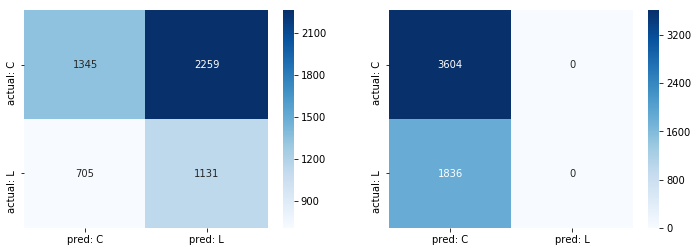

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(metrics.confusion_matrix(pred_df['y_actual'], pred_df['y_pred']), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues', 
            ax=ax[0])

sns.heatmap(metrics.confusion_matrix(pred_df['y_actual'],  np.zeros(pred_df.shape[0])), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[1])

plt.show()

# Model 2: Random Forest Classifier

In [180]:
# Read in cleaned up data
post_df = pd.read_json('complete_elmo.json', orient='split', dtype={'elmo_embedding':'float32'})
post_df['elmo_embedding'] = post_df['elmo_embedding'].apply(lambda x: np.array(x, dtype='float32'))

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(post_df['elmo_embedding'].tolist(),
                                                    post_df['political_leaning'],
                                                    test_size = 0.2)

In [ ]:
# Define classifier, over sampler, under sampler and feature selector
model = RandomForestClassifier(n_jobs=10)
osmpl = over_sampling.SMOTE(kind='regular', n_jobs=10)
usmpl = under_sampling.EditedNearestNeighbours(n_neighbors=5, n_jobs=10)

# Create pipeline
pipe = pipeline.Pipeline([('over_sampler', osmpl), ('under_sampler', usmpl), ('classifier', model)])

gs_parameter = dict(classifier__n_estimators=np.arange(300, 600, 100), 
                    classifier__max_depth=np.arange(100,400, 100))

grid_search = model_selection.GridSearchCV(pipe,
                                           param_grid=gs_parameter,
                                           scoring='f1_macro',
                                           cv=5)

grid_search.fit(X_train, y_train)

In [181]:
# Define classifier, over sampler, under sampler and feature selector
pipe_model = RandomForestClassifier(n_jobs=10, n_estimators=100)
osmpl = over_sampling.SMOTE(n_jobs=10)
usmpl = under_sampling.TomekLinks(n_jobs=10)

# Create pipeline
pipe = pipeline.Pipeline([('over_sampler', osmpl), ('under_sampler', usmpl), ('classifier', pipe_model)])

# Fit pipeline
start_time = time.time()
pipe.fit(X_train, y_train)
print('%s seconds' % (time.time() - start_time))

220.11575508117676 seconds


In [182]:
start_time = time.time()
model = RandomForestClassifier(n_estimators=100,
                               n_jobs=10,
                               class_weight='balanced')
model.fit(X_train, y_train)
print('%s seconds' % (time.time() - start_time))

13.681684732437134 seconds


In [183]:
print('Dummy Model')
print(metrics.classification_report(y_test, np.zeros(y_test.shape[0])))
print('With Over/Under Sampling')
print(metrics.classification_report(y_test, pipe.predict(X_test)))
print('Regular RandomForest')
print(metrics.classification_report(y_test, model.predict(X_test)))

Dummy Model
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      3585
           1       0.00      0.00      0.00      1855

    accuracy                           0.66      5440
   macro avg       0.33      0.50      0.40      5440
weighted avg       0.43      0.66      0.52      5440

With Over/Under Sampling
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      3585
           1       0.66      0.43      0.52      1855

    accuracy                           0.73      5440
   macro avg       0.71      0.66      0.67      5440
weighted avg       0.72      0.73      0.71      5440

Regular RandomForest
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      3585
           1       0.79      0.25      0.38      1855

    accuracy                           0.72      5440
   macro avg       0.75      0.61      0.60      5440
weighted avg    

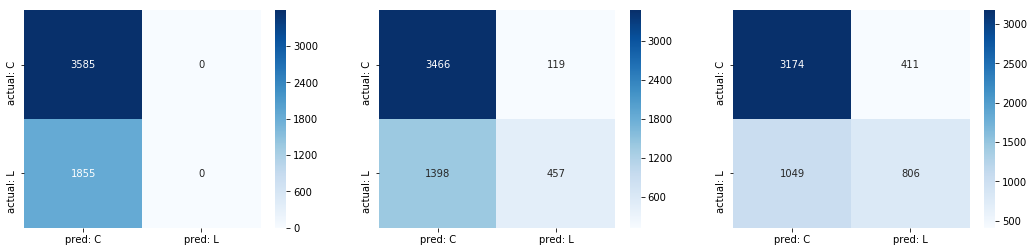

In [185]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
sns.heatmap(metrics.confusion_matrix(y_test, np.zeros(y_test.shape[0])), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues', 
            ax=ax[0])

sns.heatmap(metrics.confusion_matrix(y_test, model.predict(X_test)), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[1])

sns.heatmap(metrics.confusion_matrix(y_test, pipe.predict(X_test)), 
            xticklabels=['pred: C', 'pred: L'],
            yticklabels=['actual: C', 'actual: L'],
            annot=True,
            fmt='g',
            cmap='Blues',
            ax=ax[2])

plt.show()

In [186]:
post_df.head()

,title_clean,elmo_embedding,political_leaning
0,what was the moment or event that made you rea...,"[-0.078861244, -0.113778666, 0.0038933286, -0....",0
1,congratulations we have a guess when we hit 20...,"[-0.34211433, -0.33793145, -0.08896699, -0.123...",0
2,what are your opinions on the prohibition of m...,"[-0.04286085, -0.03858882, -0.025878163, -0.07...",0
3,they keep citing violence against transgender ...,"[-0.07348777, 0.20026228, -0.059132166, -0.123...",0
4,why is rpolitics so biased and attack you for ...,"[-0.11819296, -0.24966277, 0.17514223, -0.2276...",0


 # Misc

In [52]:
sample_df = title_df.sample(n=40)[['title', 'political_leaning']]
sample_df['title_clean'] = sample_df['title'].apply(cleanText)
sample_df['word_token'] = sample_df['title_clean'].apply(nltk.word_tokenize)
sample_df['word_count'] = sample_df['word_token'].apply(lambda x: len(x))
sample_df = sample_df[sample_df['word_count']!=0].reset_index(drop=True)

X = np.array(sample_df['title_clean'])
y = np.array(sample_df['political_leaning'])


In [53]:
batch_size = 40
X_list = [X[i:i+batch_size] for i in range(0, X.shape[0], batch_size)]

X_vecs = []
elmo_model = hub.Module('elmo_model', trainable=False)
for x in enumerate(X_list):
    embeddings = elmo_model(x[1], signature="default", as_dict=True)['default']
    start_time = time.time()
    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
        elmo_embedding = sess.run(embeddings)
    print('batch', x[0], 'complete - ', '%s seconds' % (time.time() - start_time))
    X_vecs += list(elmo_embedding)

batch 0 complete -  37.912352323532104 seconds


In [108]:
test = np.array(X_vecs)

In [114]:
len(test.reshape(1024, 40))

1024

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.276689,-0.208970,0.161452,-0.367481,-0.350300,0.342972,0.294842,0.491546,-0.819915,-0.316098,...,-0.393828,-0.170708,0.496214,0.386194,0.089472,0.303961,0.593291,-0.117597,-0.095643,-0.043338
1,-0.065883,-0.462591,0.436515,-0.413885,-0.026222,0.321290,0.126761,0.029787,-0.631938,-0.573457,...,-0.744268,-0.227521,0.536256,0.543125,0.171100,0.042743,0.004873,0.318132,0.359904,-0.061798
2,-0.208323,-0.420886,0.226222,-0.203480,0.200442,0.279329,-0.143750,0.138960,-0.662310,-0.196238,...,-0.070478,-0.185631,0.423570,0.186676,0.295642,0.308623,-0.011046,0.055537,0.543888,0.081874
3,-0.149617,-0.305974,-0.137444,-0.502975,0.086342,0.195782,0.078101,0.198268,-0.402344,-0.289730,...,-0.290754,0.232083,0.112073,0.446894,0.365919,0.104502,0.118330,0.030867,0.210190,0.209151
4,-0.436322,-0.841456,0.945874,-0.496957,-0.228230,0.005721,0.933724,0.269926,-0.923208,-1.584071,...,-0.075313,-0.759207,0.985262,1.109719,1.351523,0.420456,0.241377,0.473121,0.230041,-0.061766
5,-0.100416,-0.112036,0.302347,-0.128308,-0.044523,0.325321,0.018977,0.116534,-0.444550,-0.557667,...,-0.107703,0.194406,0.125755,0.413555,0.174644,0.546381,0.455114,0.199863,-0.379140,0.074198
6,-0.105381,-0.083749,0.251548,0.004007,-0.127548,0.280834,-0.082104,0.307986,-0.049660,-0.107669,...,-0.350422,-0.114725,0.324783,0.446298,0.044842,-0.028871,-0.362527,0.160749,0.047854,0.082000
7,-0.382701,-0.926469,0.823845,0.095322,-0.385038,-0.126538,0.528252,0.351982,-1.254327,-1.775305,...,-0.535517,-0.214417,0.492240,1.157385,0.919766,0.643625,0.166707,0.421746,0.206989,0.030535
8,-0.131127,-0.358225,0.152046,-0.028576,0.306485,0.212454,0.076672,0.257144,-0.423827,-0.252994,...,-0.061741,-0.102211,0.197580,0.187048,0.009398,0.142171,0.154844,0.164657,0.343222,-0.125265
9,-0.570007,-0.501499,0.745288,-0.487539,-0.012396,0.492131,0.338448,0.452459,-0.618901,-0.659314,...,0.023383,-0.293791,0.185921,0.534916,0.478675,0.422534,-0.131741,0.203161,-0.272487,0.044784
